In [4]:
from gfootball.env.scenario_builder import all_scenarios
print(all_scenarios())

['11_vs_11_competition', '11_vs_11_easy_stochastic', '11_vs_11_hard_stochastic', '11_vs_11_kaggle', '11_vs_11_stochastic', '1_vs_1_easy', '5_vs_5', 'academy_3_vs_1_with_keeper', 'academy_corner', 'academy_counterattack_easy', 'academy_counterattack_hard', 'academy_empty_goal', 'academy_empty_goal_close', 'academy_pass_and_shoot_with_keeper', 'academy_run_pass_and_shoot_with_keeper', 'academy_run_to_score', 'academy_run_to_score_with_keeper', 'academy_single_goal_versus_lazy', 'test_example_multiagent', 'tests']


We are going to use the same representation as the GRF paper, which is a 4 stacked SMMs, each stacked SMM has the shape (16 (4 timesteps * 4 channels), 72, 96)

In [2]:
import gym
import numpy as np
from gym.spaces import Box
from gfootball.env import create_environment
from gfootball.env.wrappers import SMMWrapper, SingleAgentObservationWrapper

# 1) Wrapper to turn FrameStack’s (K, H, W, C) → channels‑first (K*C, H, W)
class StackFlattenWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Unpack the FrameStack’s declared space: (K, H, W, C)
        K, H, W, C = env.observation_space.shape
        self.K = K
        self.H = H
        self.W = W
        self.C = C
        # New space is (K*C, H, W)
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(K * C, H, W),
            dtype=env.observation_space.dtype
        )

    def observation(self, obs):
        # 'obs' comes in as a LazyFrames that concatenates along axis=0:
        # array shape is (H*K, W, C)
        arr = np.asarray(obs)
        # reshape back to (K, H, W, C)
        arr = arr.reshape(self.K, self.H, self.W, self.C)
        # transpose to (K, C, H, W)
        arr = arr.transpose(0, 3, 1, 2)
        # finally flatten to (K*C, H, W)
        return arr.reshape(self.K * self.C, self.H, self.W)

# 2) Build the “stacked SMM” pipeline in one cell
env = create_environment(
    env_name='11_vs_11_stochastic',
    representation='extracted',                         # raw dict obs
    number_of_left_players_agent_controls=1,
    render=False
)

print("extracted", env.observation_space.shape)   # (1, 72, 96, 4)
env = gym.wrappers.FrameStack(env, 4)             # → LazyFrames, concatenates to (H*4, W, 4)
print("Stack frames", env.observation_space.shape)
env = StackFlattenWrapper(env)                    # → (4*4, H, W) = (16, 72, 96)
print("stack+flatten", env.observation_space.shape)

# 3) Test shape
obs = env.reset()
print(obs.shape)  # -> (16, 72, 96): matches paper’s 72×96×16 input (pytorch uses channels first and tensorflow uses channels last)

extracted (72, 96, 4)
Stack frames (4, 72, 96, 4)
stack+flatten (16, 72, 96)
(16, 72, 96)


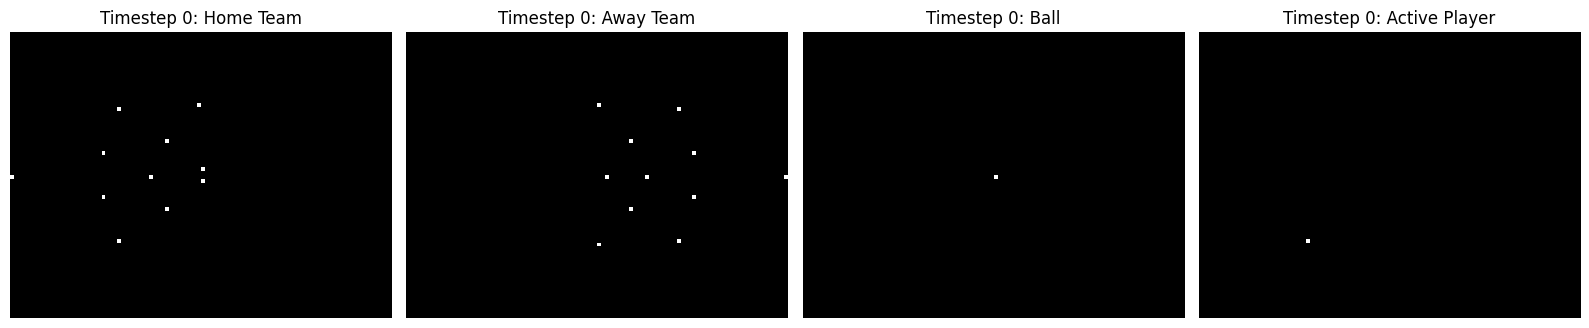

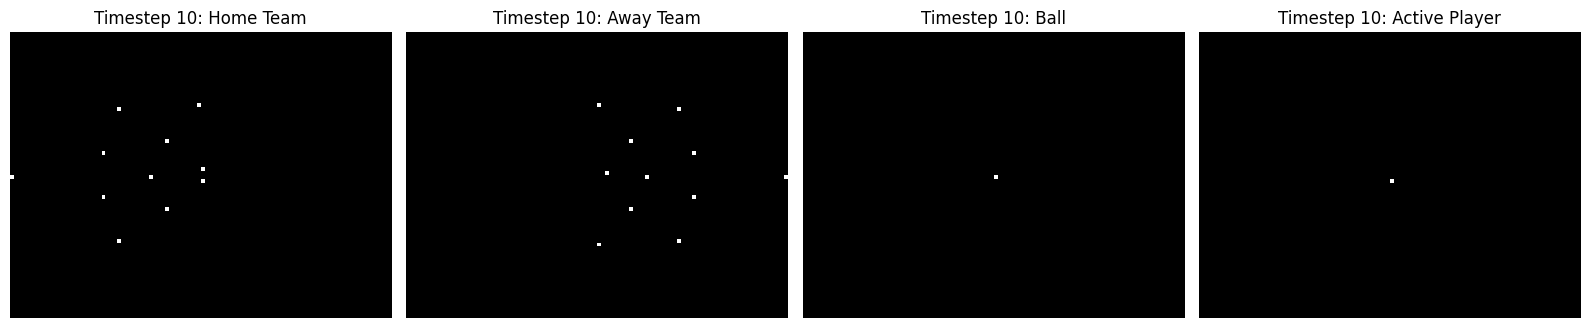

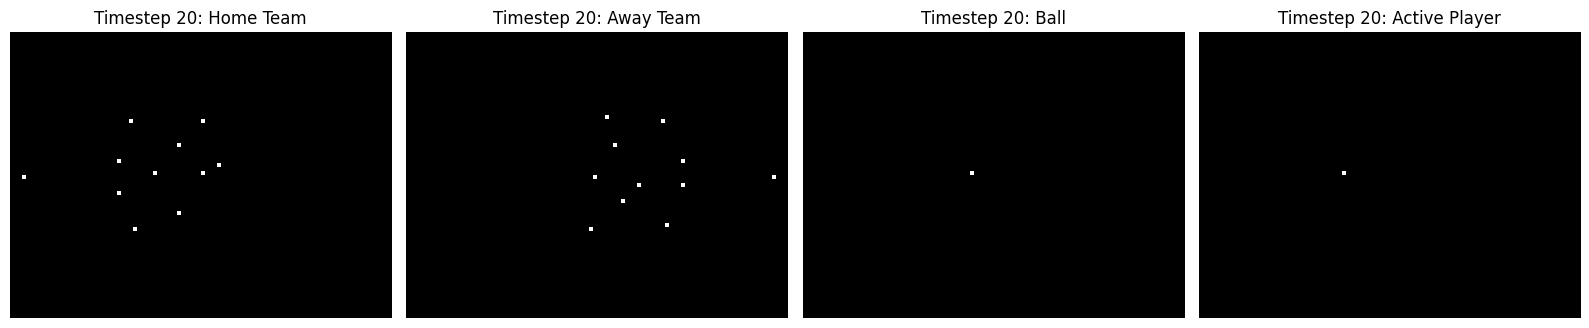

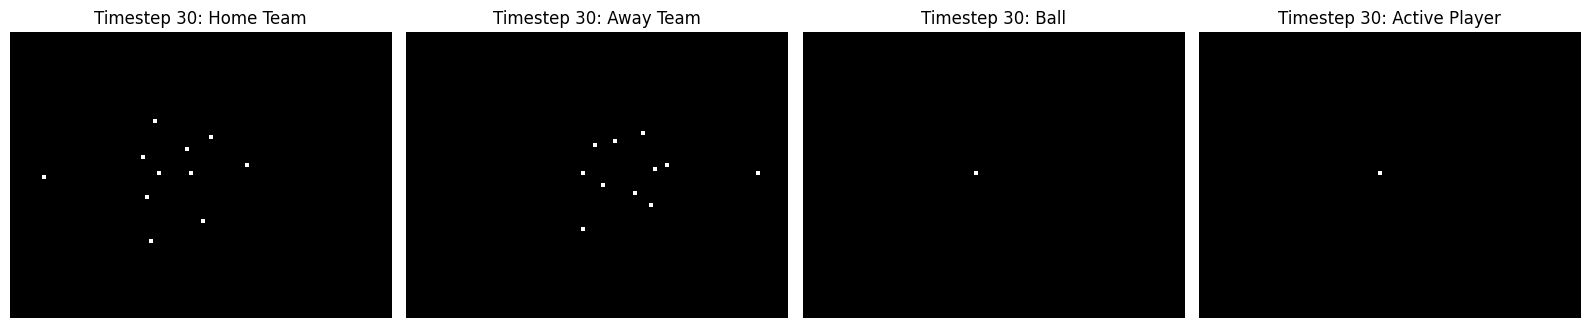

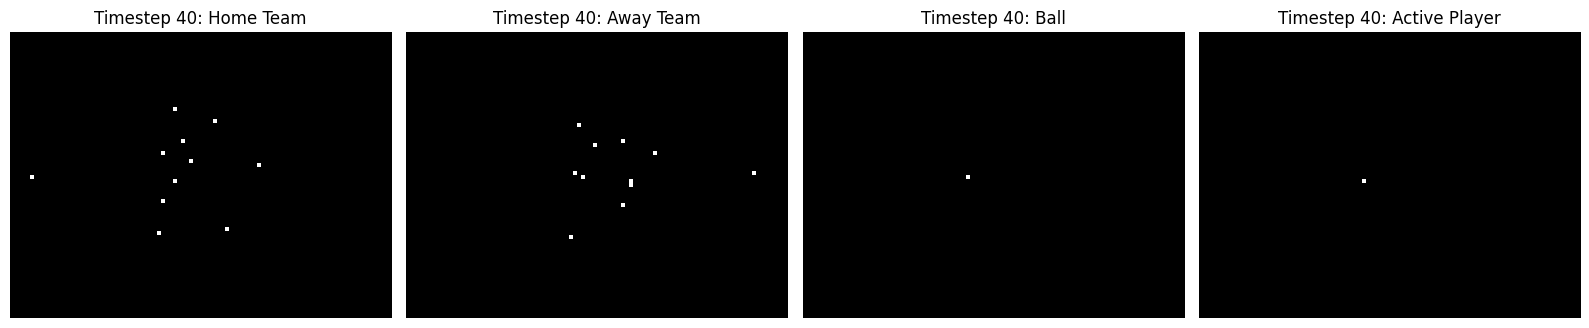

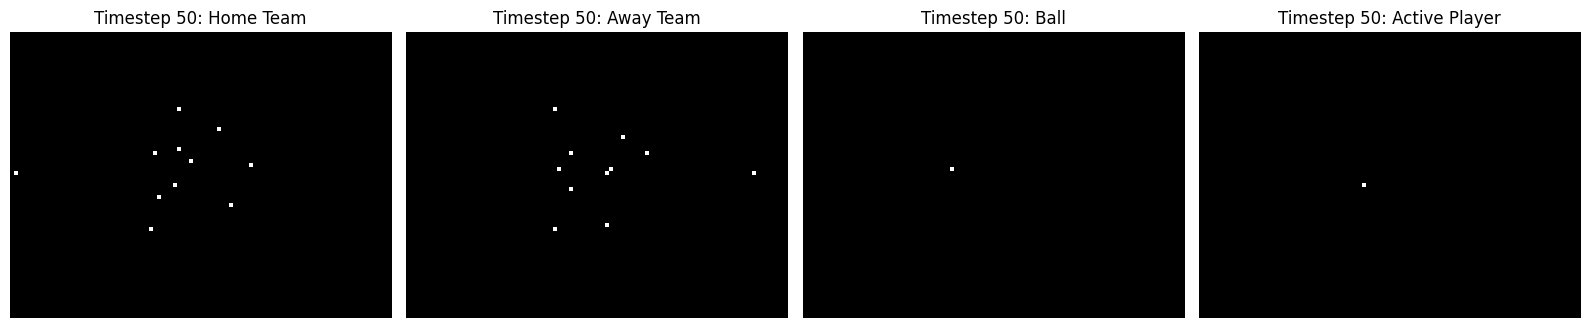

In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gfootball.env import create_environment

# 1) Create the SMM “extracted” environment
env = create_environment(
    env_name='11_vs_11_stochastic',
    representation='extracted',             # 4 minimap planes
    number_of_left_players_agent_controls=1,
    render=False
)

# 2) Reset and collect the first frame (t=0)
frames = []
obs = env.reset()  # obs.shape == (72, 96, 4)
frames.append(obs)

# 3) Step 3 more times to collect t=1,2,3
for _ in range(50):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if _ % 10 == 0:
        frames.append(obs)
    if done:
        break  # in case the episode ends early

# 4) Visualize
plane_names = ['Home Team', 'Away Team', 'Ball', 'Active Player']

for t, frame in enumerate(frames):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frame[:, :, i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Timestep {t*10}: {plane_names[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [10]:
import gym
import numpy as np
from gym.spaces import Box
import gfootball.env as football_env
from gfootball.env import create_environment as _create_env
from gfootball.env.wrappers import SMMWrapper, SingleAgentObservationWrapper
from gym.wrappers import FrameStack

# Your StackFlattenWrapper from before
class StackFlattenWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Env.space is (K, H, W, C)
        K, H, W, C = env.observation_space.shape
        self.K, self.H, self.W, self.C = K, H, W, C
        self.observation_space = Box(0, 255, (K * C, H, W), env.observation_space.dtype)

    def observation(self, obs):
        arr = np.asarray(obs)                     # (H*K, W, C)
        arr = arr.reshape(self.K, self.H, self.W, self.C)  # (K, H, W, C)
        arr = arr.transpose(0, 3, 1, 2)           # (K, C, H, W)
        return arr.reshape(self.K * self.C, self.H, self.W)

# Monkey‑patch create_environment
def create_environment(env_name: str,
                       representation: str = 'raw',
                       **kwargs):
    if representation == 'stacked_extracted':
        # 1) Get the 4‑plane extracted SMM
        env = _create_env(env_name,
                          representation='extracted',
                          **kwargs)
        # 2) Stack 4 frames
        env = FrameStack(env, 4)
        # 3) Flatten to (16,72,96)
        env = StackFlattenWrapper(env)
        return env
    else:
        # fallback to the original
        return _create_env(env_name,
                           representation=representation,
                           **kwargs)

# Override in the module
football_env.create_environment = create_environment

# --- Now you can do ---
env = football_env.create_environment(
    env_name='11_vs_11_stochastic',
    representation='stacked_extracted',
    number_of_left_players_agent_controls=1,
    render=False
)
print(env.observation_space.shape)  # -> (16, 72, 96)


(16, 72, 96)


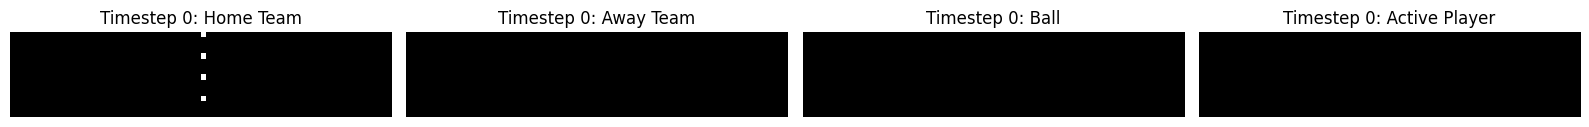

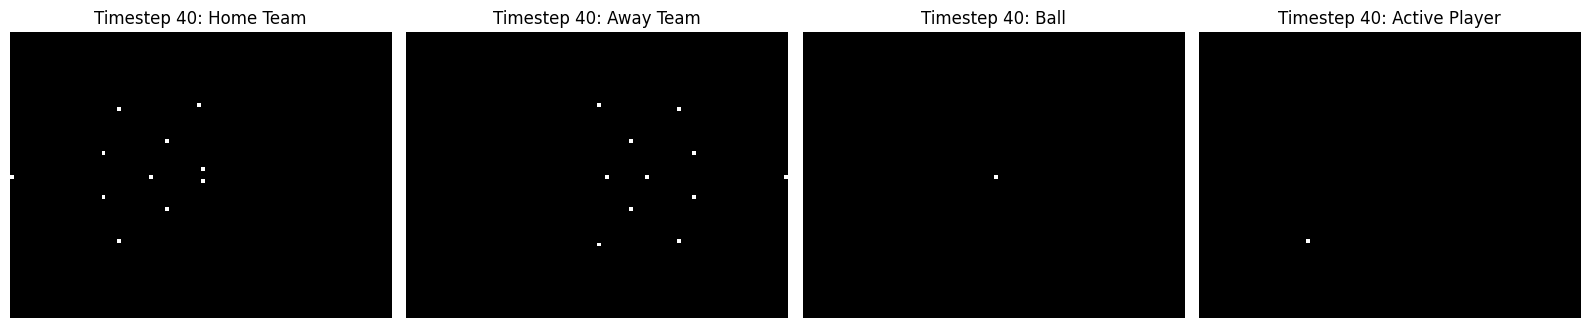

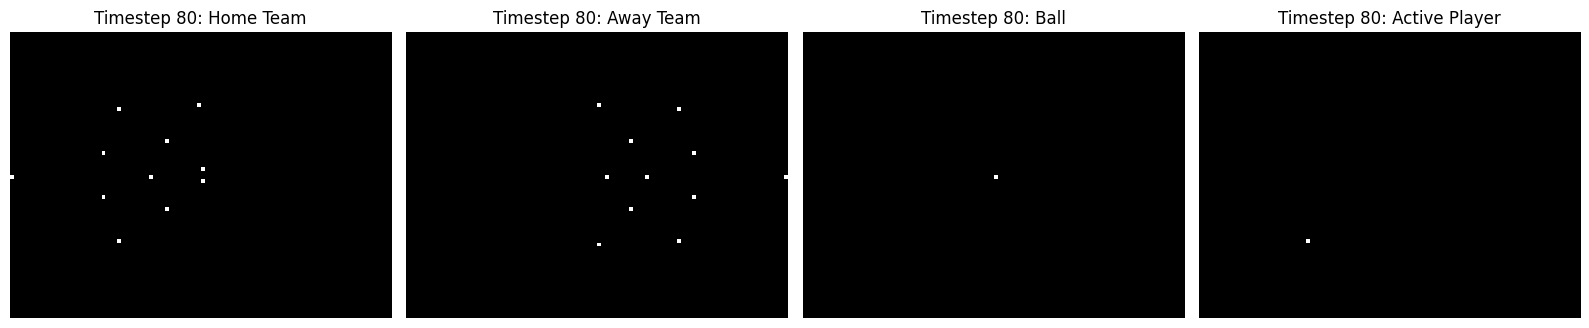

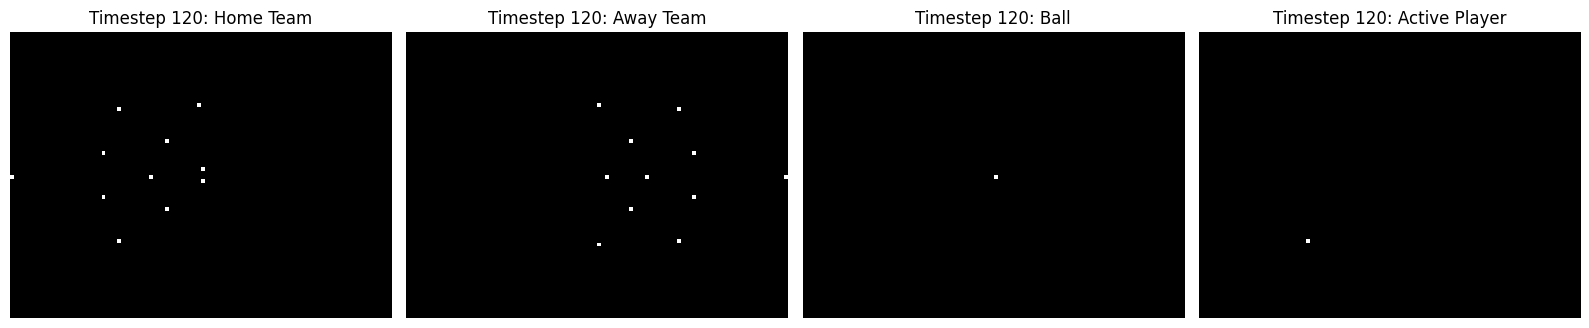

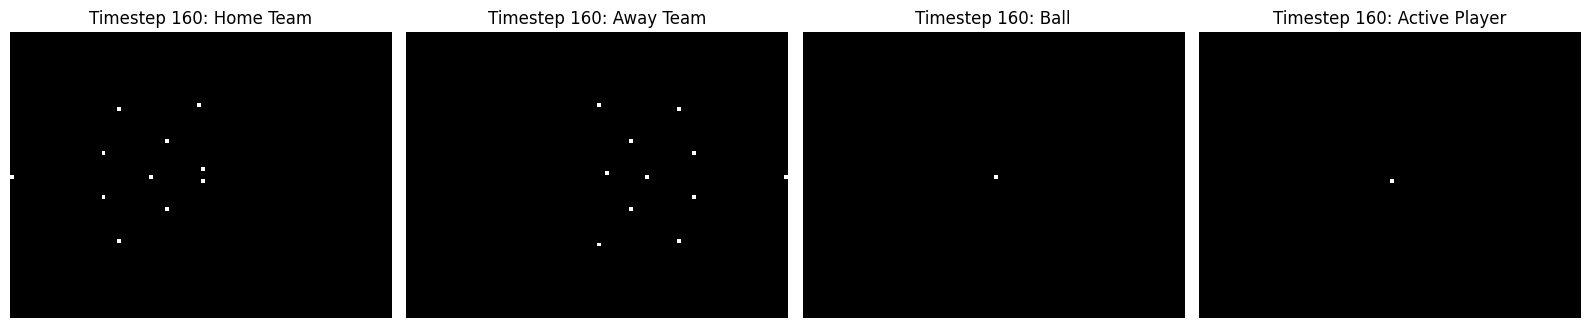

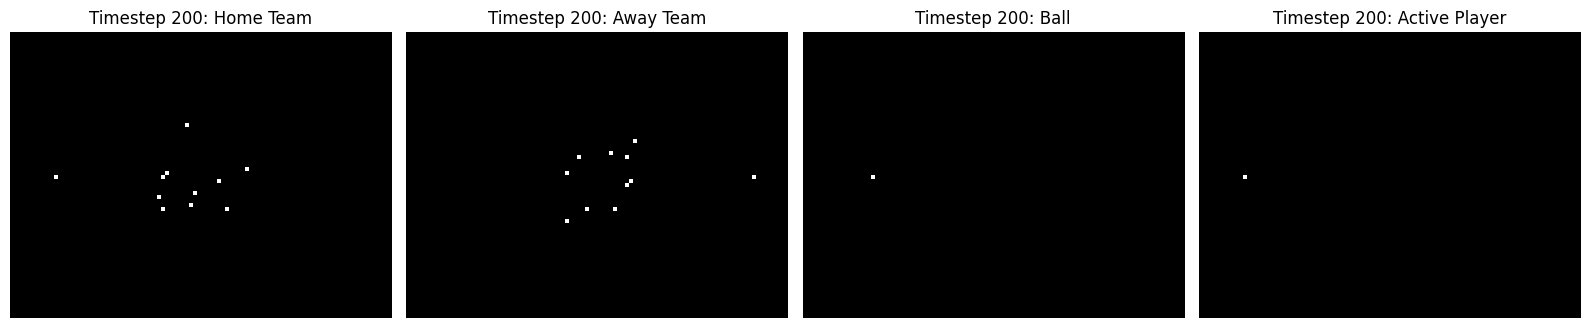

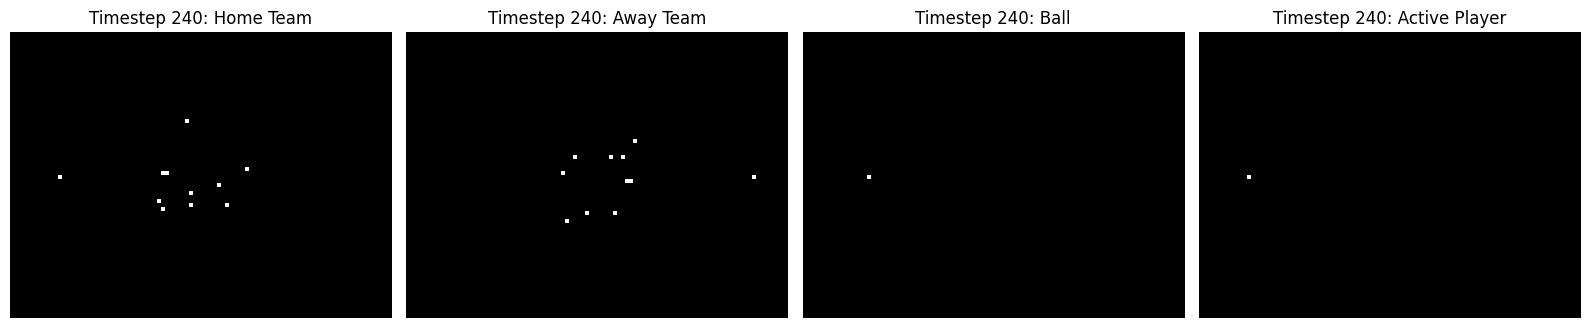

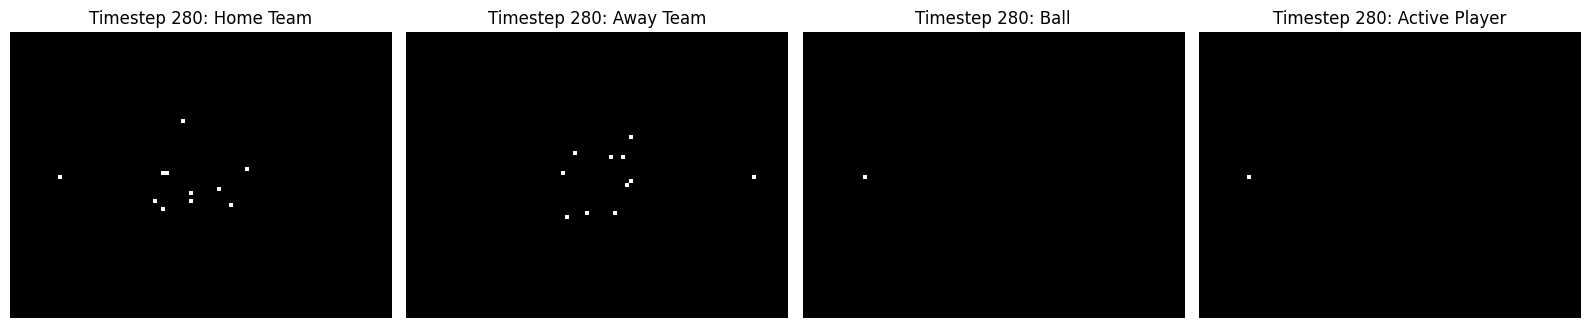

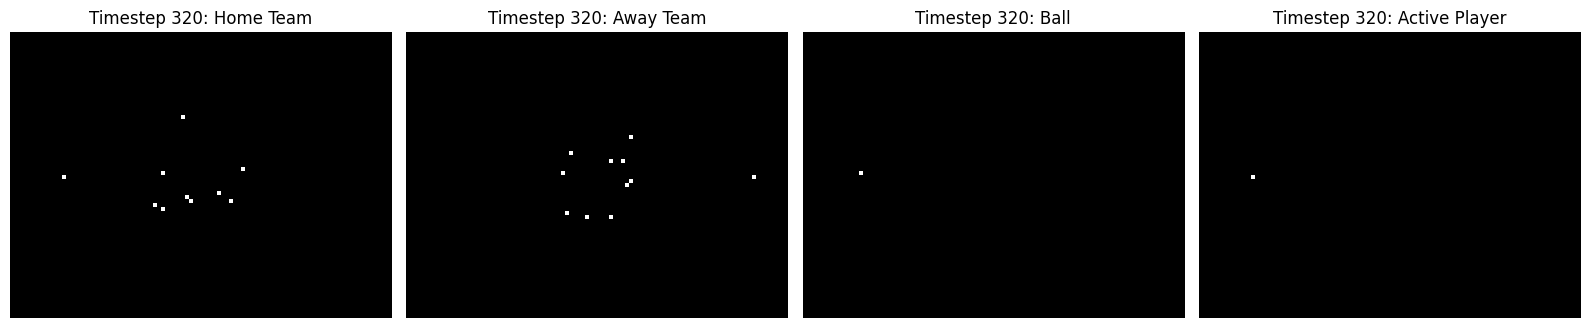

In [15]:

# 2) Reset and collect the first frame (t=0)
frames = []
obs = env.reset()  # obs.shape == (72, 96, 4)
frames.append(obs)

# 3) Step and collect every 10th stacked frame
for step in range(50):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if step % 40 == 0:
        # reshape from (16,72,96) → (stack=4, channels=4, H=72, W=96)
        obs4 = obs.reshape(4, 4, 72, 96)

        # iterate over the 4 stacked frames
        for k in range(obs4.shape[0]):
            # obs4[k] has shape (4,72,96): (channels, H, W)
            # transpose to (H, W, channels)
            img = np.transpose(obs4[k], (1, 2, 0))  # now (72,96,4)
            frames.append(img)

    if done:
        break
# 4) Visualize
plane_names = ['Home Team', 'Away Team', 'Ball', 'Active Player']

for t, frame in enumerate(frames):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(frame[:, :, i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Timestep {t*40}: {plane_names[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()